<a href="https://colab.research.google.com/github/leonardojfrenner/AppFinanceiro/blob/main/challenge4_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.8 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
base_candles = pd.read_excel('/content/Challenge 3_NFLX.xlsx')
base_candles['Date'] = pd.to_datetime(base_candles['Date'], format='%Y-%m-%d')
base_candles.set_index('Date', inplace=True)
base_candles.sort_index(inplace=True)


In [ ]:
base_candles

,Open,High,Low,Close
Date,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429
2002-05-24,1.214286,1.225000,1.197143,1.210000
2002-05-28,1.213571,1.232143,1.157143,1.157143
2002-05-29,1.164286,1.164286,1.085714,1.103571
2002-05-30,1.107857,1.107857,1.071429,1.071429
...,...,...,...,...
2022-05-27,193.190002,195.250000,190.369995,195.190002
2022-05-31,196.179993,199.949997,190.800003,197.440002
2022-06-01,198.699997,202.740005,191.660004,192.910004


In [ ]:
base_candles['body'] = base_candles['Open'] - base_candles['Close']
base_candles['candle_size'] = (base_candles['High'] - base_candles['Low'])*100
base_candles['body_percentage'] = (base_candles['body'] / base_candles['candle_size'])*100
base_candles['upper_shadow'] = (base_candles['High'] - base_candles[['Open', 'Close']].max(axis=1)) / base_candles['candle_size']*100
base_candles['lower_shadow'] = (base_candles[['Open', 'Close']].min(axis=1) - base_candles['Low'])/ base_candles['candle_size']*100
base_candles['type'] = base_candles.apply(
    lambda row: 'Bearish' if row['Open'] > row['Close'] else 'Bullish',
    axis=1
)


base_candles

,Open,High,Low,Close,body,candle_size,body_percentage,upper_shadow,lower_shadow,type
Date,,,,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,-0.040000,9.7143,-0.411764,0.477935,0.110301,Bullish
2002-05-24,1.214286,1.225000,1.197143,1.210000,0.004286,2.7857,0.153857,0.384607,0.461536,Bearish
2002-05-28,1.213571,1.232143,1.157143,1.157143,0.056428,7.5000,0.752373,0.247627,0.000000,Bearish
2002-05-29,1.164286,1.164286,1.085714,1.103571,0.060715,7.8572,0.772731,0.000000,0.227269,Bearish
2002-05-30,1.107857,1.107857,1.071429,1.071429,0.036428,3.6428,1.000000,0.000000,0.000000,Bearish
...,...,...,...,...,...,...,...,...,...,...
2022-05-27,193.190002,195.250000,190.369995,195.190002,-2.000000,488.0005,-0.409836,0.012295,0.577870,Bullish
2022-05-31,196.179993,199.949997,190.800003,197.440002,-1.260009,914.9994,-0.137706,0.274317,0.587977,Bullish
2022-06-01,198.699997,202.740005,191.660004,192.910004,5.789993,1108.0001,0.522562,0.364622,0.112816,Bearish


In [ ]:
colunas = base_candles.columns
x_candles = base_candles.iloc[:,0:10].values
colunas

Index(['Open', 'High', 'Low', 'Close', 'body', 'candle_size',
       'body_percentage', 'upper_shadow', 'lower_shadow', 'type'],
      dtype='object')

In [ ]:
x_candles[0]

array([1.156429, 1.242857, 1.145714, 1.196429, -0.040000000000000036,
       9.71430000000002, -0.4117641003469108, 0.47793459127266036,
       0.11030130838042894, 'Bullish'], dtype=object)

In [ ]:
label_encoder_type = LabelEncoder()
x_candles[:,9] = label_encoder_type.fit_transform(x_candles[:,9])
onehotenconder_candles = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [9])], remainder='passthrough')
x_candles = onehotenconder_candles.fit_transform(x_candles)
x_candles[0]

array([0.0, 1.0, 1.156429, 1.242857, 1.145714, 1.196429,
       -0.040000000000000036, 9.71430000000002, -0.4117641003469108,
       0.47793459127266036, 0.11030130838042894], dtype=object)

In [ ]:
scaler_candles = StandardScaler()
x_candles_scaler = scaler_candles.fit_transform(x_candles)
x_candles_scaler[0]

array([-1.01639126,  1.01639126, -0.68343242, -0.68368321, -0.68290611,
       -0.68342055, -0.01238436, -0.59575636, -0.77206626,  1.07230397,
       -0.79646014])

In [ ]:
cluster_candles = x_candles_scaler[:, [0,1,7,8,9,10]]
cluster_candles[0]

array([-1.01639126,  1.01639126, -0.59575636, -0.77206626,  1.07230397,
       -0.79646014])

In [ ]:
kmeans_candles = KMeans(n_clusters=243, random_state=0)
rotulos = kmeans_candles.fit_predict(cluster_candles)
rotulos

array([136,  13, 228, ...,  40,  41,  53], dtype=int32)

In [ ]:
np.unique(rotulos, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [ ]:
base_candles['cluster_kmeans'] = rotulos


fig = go.Figure()


fig.add_trace(
    go.Candlestick(
        x=base_candles.index,
        open=base_candles['Open'],
        high=base_candles['High'],
        low=base_candles['Low'],
        close=base_candles['Close'],
        name='Candlesticks'
    )
)
for i in range(len(base_candles)):
    fig.add_trace(
        go.Scatter(
            x=[base_candles.index[i]],
            y=[base_candles['High'][i] + 0.5],
            text=[str(base_candles['cluster_kmeans'][i])],
            mode="text",
            textfont=dict(color="black", size=10),
            showlegend=False
        )
    )

fig.update_layout(
    title="Gráfico de Candlesticks com Clusters",
    xaxis_title="Data",
    yaxis_title="Preço",
    xaxis_rangeslider_visible=False,
    template="plotly_white"
)

fig.show()


<ipython-input-48-ebd1216f4f48>:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-48-ebd1216f4f48>:22: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
base_candles

,Open,High,Low,Close,body,candle_size,body_percentage,upper_shadow,lower_shadow,type,cluster_kmeans
Date,,,,,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,-0.040000,9.7143,-0.411764,0.477935,0.110301,Bullish,136
2002-05-24,1.214286,1.225000,1.197143,1.210000,0.004286,2.7857,0.153857,0.384607,0.461536,Bearish,13
2002-05-28,1.213571,1.232143,1.157143,1.157143,0.056428,7.5000,0.752373,0.247627,0.000000,Bearish,228
2002-05-29,1.164286,1.164286,1.085714,1.103571,0.060715,7.8572,0.772731,0.000000,0.227269,Bearish,201
2002-05-30,1.107857,1.107857,1.071429,1.071429,0.036428,3.6428,1.000000,0.000000,0.000000,Bearish,24
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27,193.190002,195.250000,190.369995,195.190002,-2.000000,488.0005,-0.409836,0.012295,0.577870,Bullish,169
2022-05-31,196.179993,199.949997,190.800003,197.440002,-1.260009,914.9994,-0.137706,0.274317,0.587977,Bullish,217
2022-06-01,198.699997,202.740005,191.660004,192.910004,5.789993,1108.0001,0.522562,0.364622,0.112816,Bearish,40


In [ ]:
base_candles.drop(columns=['body','candle_size','body_percentage','upper_shadow','lower_shadow','type'], inplace=True)
base_candles

,Open,High,Low,Close,cluster_kmeans
Date,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,136
2002-05-24,1.214286,1.225000,1.197143,1.210000,13
2002-05-28,1.213571,1.232143,1.157143,1.157143,228
2002-05-29,1.164286,1.164286,1.085714,1.103571,201
2002-05-30,1.107857,1.107857,1.071429,1.071429,24
...,...,...,...,...,...
2022-05-27,193.190002,195.250000,190.369995,195.190002,169
2022-05-31,196.179993,199.949997,190.800003,197.440002,217
2022-06-01,198.699997,202.740005,191.660004,192.910004,40


In [ ]:
from google.colab import files
cols_to_check = ['Open', 'High', 'Low', 'Close', 'cluster_kmeans']
base_candles[cols_to_check] = base_candles[cols_to_check].apply(pd.to_numeric)
base_candles.to_csv('/content/base_candles.csv', index=True)
files.download('/content/base_candles.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Aplicando HMM com python

In [ ]:
pip install pomegranate hmmlearn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.1 MB/s eta 0:00:00
   ━

In [ ]:
from hmmlearn.hmm import GaussianHMM


In [ ]:
base_candles['Variacao_Alta'] = (base_candles['High'] - base_candles['Open']) / base_candles['Open']
base_candles['Variacao_Baixa'] = (base_candles['Low'] - base_candles['Close']) / base_candles['Close']

base_candles['Retorno'] = base_candles['Close'].pct_change()

#desvio padrão dos retornos diários em uma janela de 5 dias
base_candles['Volatilidade'] = base_candles['Retorno'].rolling(window=5).std()

# Remover valores NaN gerados pela volatilidade
base_candles.dropna(inplace=True)

# Criar matriz para o HMM
X = base_candles[['Variacao_Alta', 'Variacao_Baixa', 'Volatilidade']].values

base_candles[['Variacao_Alta', 'Variacao_Baixa', 'Volatilidade']].head()


,Variacao_Alta,Variacao_Baixa,Volatilidade
Date,,,
2002-05-31,0.000000,-0.004645,0.027040
2002-06-03,0.064154,-0.046202,0.039990
2002-06-04,0.003774,-0.006390,0.036220
2002-06-05,0.043730,-0.034869,0.030257
2002-06-06,0.071429,-0.028399,0.022708


In [ ]:
data_inicio = "2022-02-18"
data_fim = "2022-05-25"

dados_filtrados = base_candles.loc[data_inicio:data_fim].copy()

# quantidade minima
if len(dados_filtrados) < 10:
    raise ValueError("Intervalo muito curto! Escolha um período maior.")

X_filtrado = dados_filtrados[['Variacao_Alta', 'Variacao_Baixa', 'Volatilidade']].values

# n de estados ocultos
num_estados = 3

modelo_hmm = GaussianHMM(n_components=num_estados, covariance_type="diag", n_iter=1000, random_state=42)
modelo_hmm.fit(X_filtrado)



GaussianHMM(n_components=3, n_iter=1000, random_state=42)

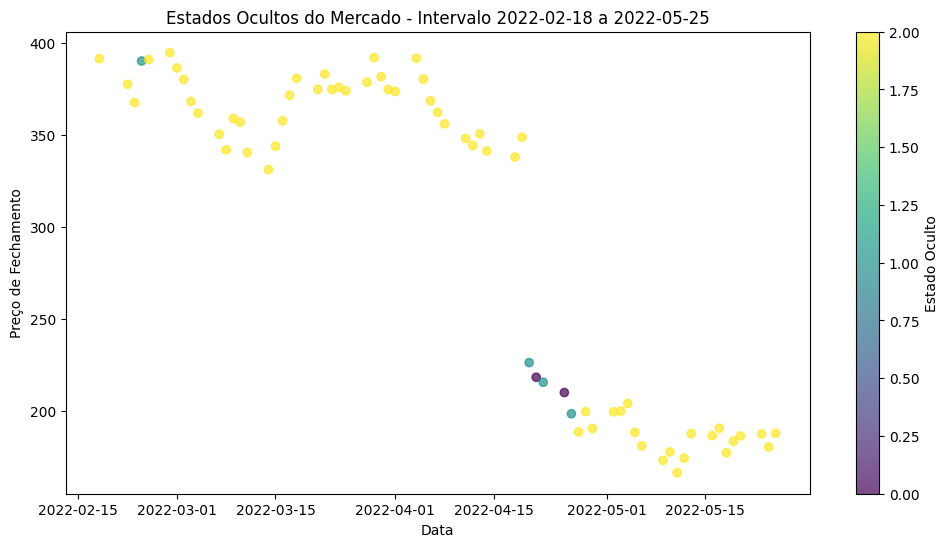

In [ ]:
# Prever os estados ocultos para os dados filtrados
dados_filtrados['Estado_Oculto'] = modelo_hmm.predict(X_filtrado)

# Gráfico dos estados ocultos no intervalo selecionado
plt.figure(figsize=(12, 6))
plt.scatter(dados_filtrados.index, dados_filtrados['Close'], c=dados_filtrados['Estado_Oculto'], cmap='viridis', alpha=0.7)
plt.colorbar(label="Estado Oculto")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.title(f"Estados Ocultos do Mercado - Intervalo {data_inicio} a {data_fim}")
plt.show()


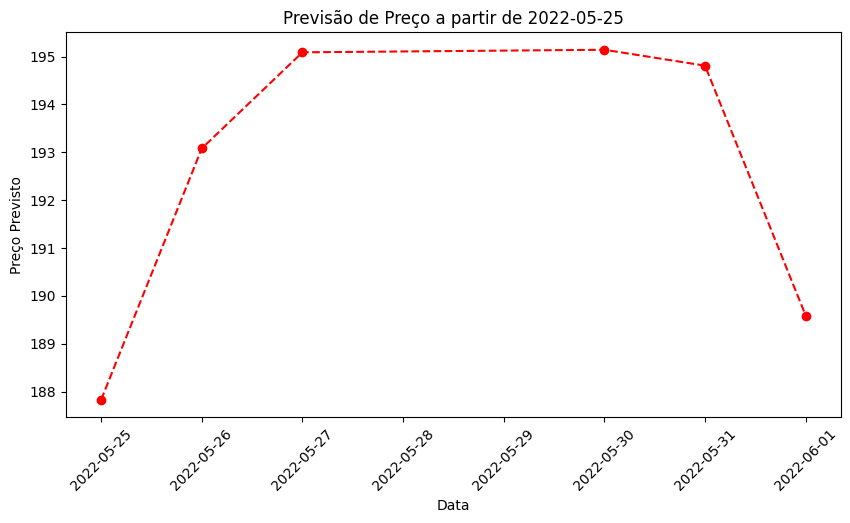

In [ ]:
dias_futuros = 5
estado_atual = modelo_hmm.predict(X_filtrado[-1].reshape(1, -1))[0]  # Último estado oculto
retornos_simulados, _ = modelo_hmm.sample(dias_futuros)  # Simular retornos futuros

# Calcular preços futuros a partir do último preço de fechamento no intervalo
preco_atual = dados_filtrados['Close'].iloc[-1]
precos_futuros = [preco_atual]

for retorno in retornos_simulados[:, 0]:  # Usar os retornos simulados
    precos_futuros.append(precos_futuros[-1] * (1 + retorno))  # Aplicar retorno percentual

# Criar um eixo de datas futuras para visualizar a previsão
datas_futuras = pd.date_range(start=dados_filtrados.index[-1], periods=dias_futuros+1, freq='B')

plt.figure(figsize=(10, 5))
plt.plot(datas_futuras, precos_futuros, marker='o', linestyle='--', color='r')
plt.xlabel("Data")
plt.ylabel("Preço Previsto")
plt.title(f"Previsão de Preço a partir de {data_fim}")
plt.xticks(rotation=45)
plt.show()


In [ ]:
base_candles.loc[data_fim:].iloc[1:6]

,Open,High,Low,Close,cluster_kmeans,Retorno,Volatilidade,Diferenca_Preco,Estado_Oculto,Variacao_Alta,Variacao_Baixa
Date,,,,,,,,,,,
2022-05-26,186.490005,192.339996,183.089996,191.399994,213,0.019007,0.029198,4.909989,1,0.031369,-0.043417
2022-05-27,193.190002,195.250000,190.369995,195.190002,169,0.019802,0.029498,2.000000,1,0.010663,-0.024694
2022-05-31,196.179993,199.949997,190.800003,197.440002,217,0.011527,0.029424,1.260009,1,0.019217,-0.033630
2022-06-01,198.699997,202.740005,191.660004,192.910004,40,-0.022944,0.023385,-5.789993,1,0.020332,-0.006480
2022-06-02,192.020004,205.470001,191.720001,205.089996,41,0.063138,0.030659,13.069992,1,0.070045,-0.065191


In [ ]:
# Três Possíveis Estados Ocultos no Mercado

# Mercado de Tendência de Alta (Bullish)

# Alta variação positiva (Variacao_Alta alta).
# Baixa variação negativa (Variacao_Baixa baixa).
# Volatilidade moderada (oscila, mas mantém viés de alta).
# Indica um mercado otimista, com preços subindo de forma consistente.

# Mercado de Tendência de Baixa (Bearish)

# Alta variação negativa (Variacao_Baixa alta).
# Baixa variação positiva (Variacao_Alta baixa).
# Volatilidade alta (oscila muito, mas tende a cair).
# Indica um mercado pessimista, com preços caindo rapidamente.

# Mercado Lateral (Consolidado)

# Variacao_Alta e Variacao_Baixa moderadas (sem grandes oscilações).
# Volatilidade baixa (preço está estável).
# O mercado não tem direção clara, com compradores e vendedores equilibrados.